### In each data fold, there is a raw data subfolder and a syn data subfolder, which represent the raw data collection without synchronisation but with high precise timestep, and the synchronised data but without high precise timestep.


## Here is the header of the sensor file and ground truth file.

## vicon (vi*.csv)

Time  Header  translation.x translation.y translation.z rotation.x rotation.y rotation.z rotation.w

## Sensors (imu*.csv)

Time attitude_roll(radians) attitude_pitch(radians) attitude_yaw(radians) rotation_rate_x(radians/s) rotation_rate_y(radians/s) rotation_rate_z(radians/s) gravity_x(G) gravity_y(G) gravity_z(G) user_acc_x(G) user_acc_y(G) user_acc_z(G) magnetic_field_x(microteslas) magnetic_field_y(microteslas) magnetic_field_z(microteslas)

In [101]:
! pip install numpy.quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [102]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *
from pathlib import Path
from scipy.spatial.transform import Rotation

In [103]:
def get_dataset(root_dir, data_list):
    
    sequence = OxfordGlobSpeedSequence(osp.join(root_dir, data_list))
    return sequence.features


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list)

## Domain accelerations

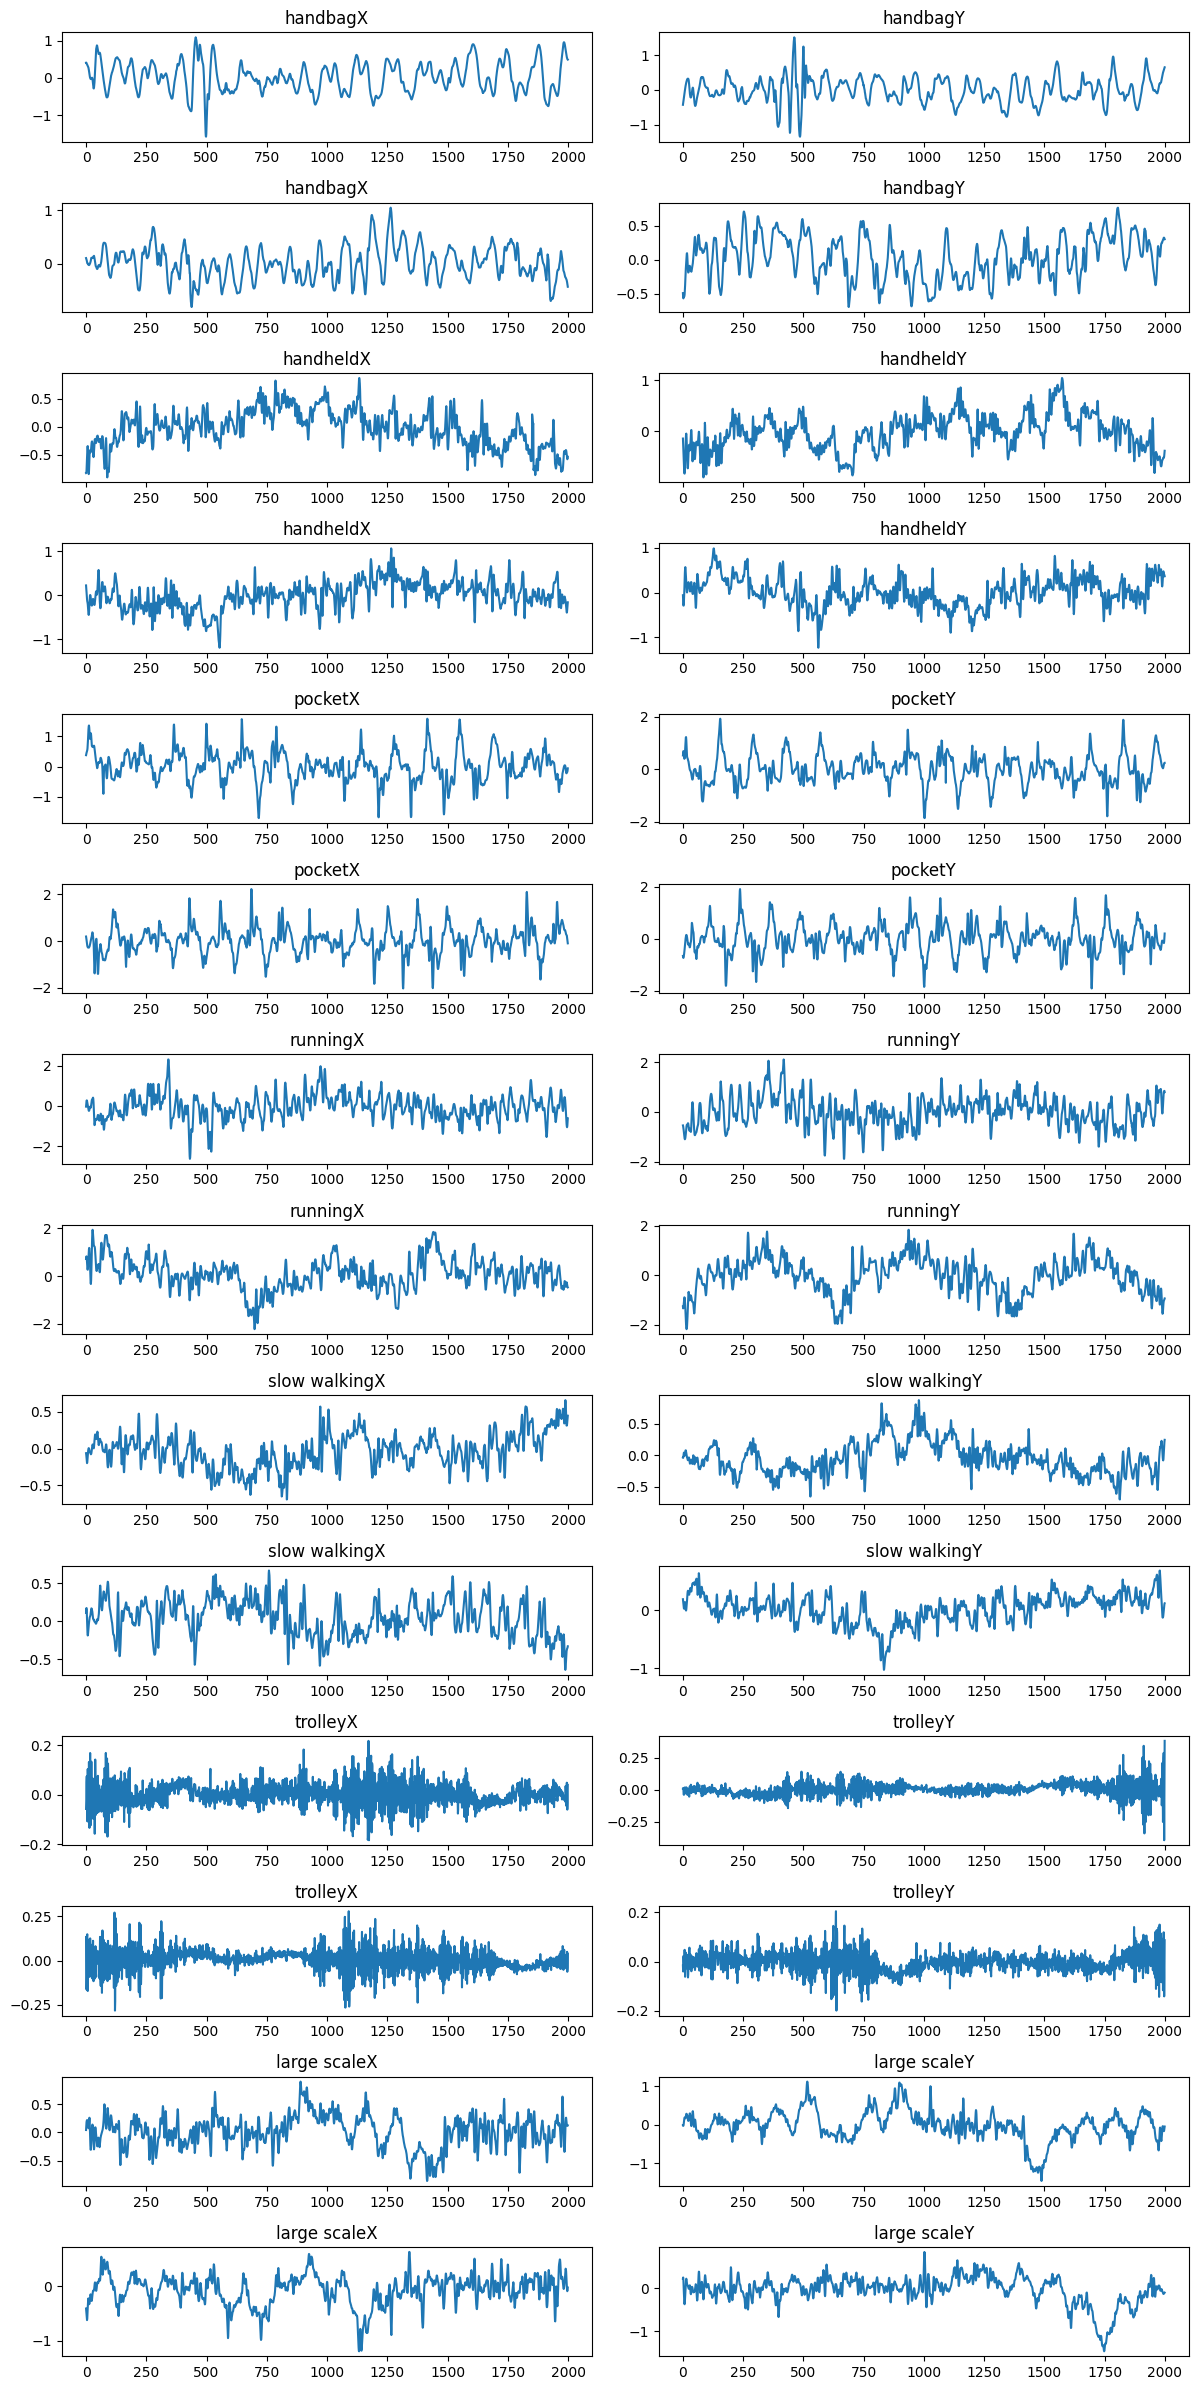

In [104]:
fig, axes = plt.subplots(nrows=14, ncols=2, figsize=(12, 24))
dataset_folder = osp.join(Path(os.getcwd()).parents[2], 'localisation_datasets')


data_path_list = ['handbag/data1/combined1.csv', 'handbag/data1/combined2.csv', 'handheld/data1/combined1.csv', 'handheld/data1/combined2.csv', 'pocket/data1/combined1.csv', 'pocket/data1/combined2.csv',
                  'running/data1/combined1.csv', 'running/data1/combined2.csv', 'slow walking/data1/combined1.csv', 'slow walking/data1/combined2.csv',
                  'trolley/data1/combined1.csv', 'trolley/data1/combined2.csv', 'large scale/floor1/combined1.csv','large scale/floor1/combined2.csv']
#data_path_list = ['handbag/data1/combined1.csv']

# Access each subplot individually
for i in range(14):
    data_path = data_path_list[i]
    data = get_dataset(dataset_folder+'/Oxford Inertial Odometry Dataset/', data_path)
    acc_data = data[:,:3]
    direction = ['X','Y']
    for j in range(2):
        ax = axes[i, j]
        ax.plot(acc_data[3000:5000,j])  # Example plot on each subplot
        seq_name = data_path.split('/')[0]
        ax.set_title(seq_name + direction[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Finding out error of accelerations

In [253]:
dataset_folder = osp.join(Path(os.getcwd()).parents[2], 'localisation_datasets')
data = pd.read_csv(dataset_folder+'/Oxford Inertial Odometry Dataset/handbag/data1/combined1.csv').iloc[200:2000,:]
position = data[['translation.x', 'translation.y', 'translation.z']].values
initial_pos = position[0,:]
pred_acceleration = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values * 9.80665

quaternion = data[['rotation.x', 'rotation.y', 'rotation.z', 'rotation.w',]].values

# Create a rotation object from the quaternion
rotation = Rotation.from_quat(quaternion)

glob_pred_acceleration = rotation.apply(pred_acceleration)

In [254]:
import numpy as np

time_arr = np.linspace(0, len(data)*0.01, num = len(data))
dt = (time_arr[1:] - time_arr[:-1])[:, None]
velocity = (position[1:] - position[:-1]) / dt 
velocity = np.vstack((velocity, np.zeros((1, 3))))

# Calculate acceleration
acceleration = (velocity[1:] - velocity[:-1]) / dt
acceleration = np.vstack((acceleration, np.zeros((1, 3))))

### Verify velocity sums to position

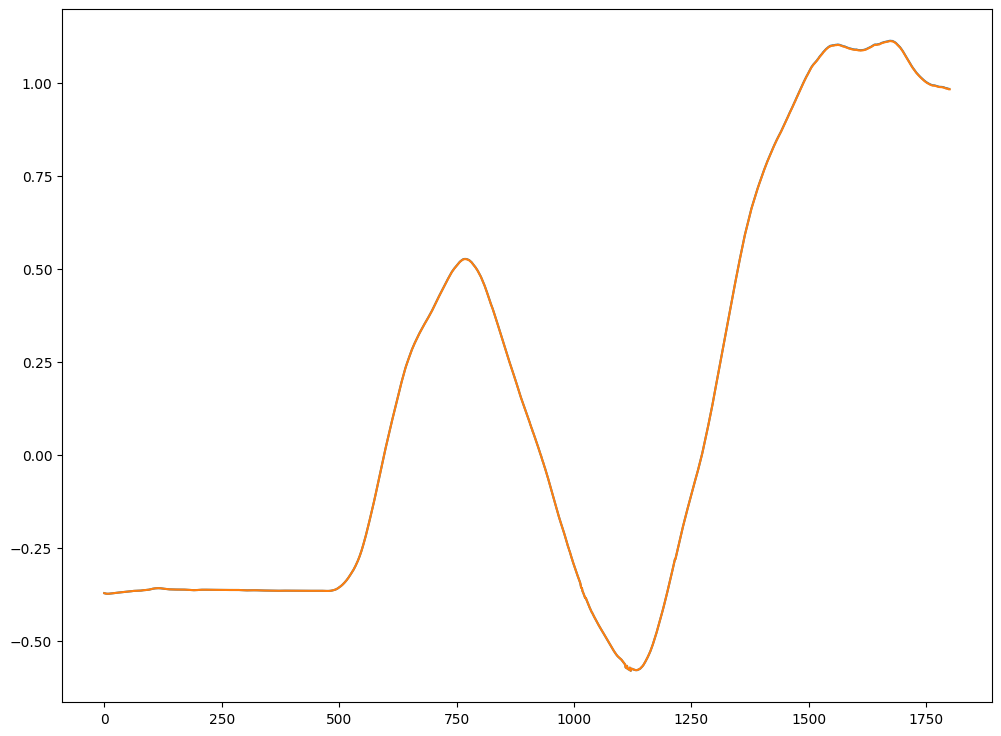

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(position[:,0])
velocity_pos = np.cumsum(np.insert(velocity[:,0]* 0.01, 0, initial_pos[0], axis = 0)) 
ax.plot(velocity_pos, marker = '.', markersize = 0.001)

### Verify acceleration sums to velocity

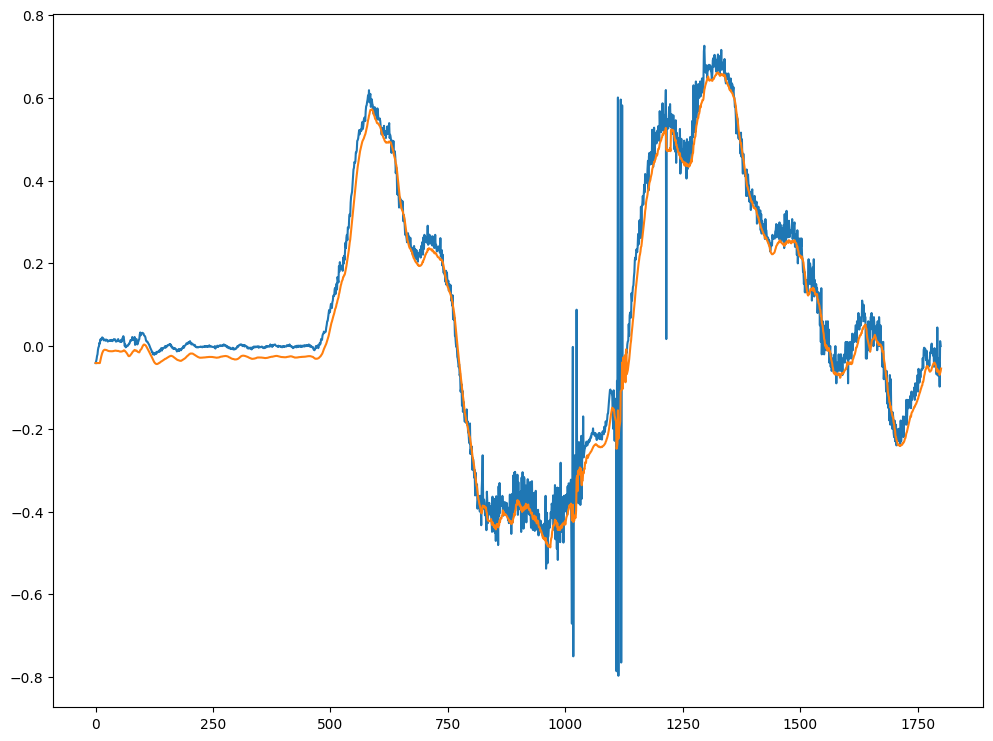

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))


acc_pos = np.cumsum(np.insert(smooth_acceleration_x* 0.01, 0, velocity[0,0], axis = 0)) 
ax.plot(velocity[:,0])
ax.plot(acc_pos, marker = '.', markersize = 0.001)

### Smoothened acceleration with predicted acceleration

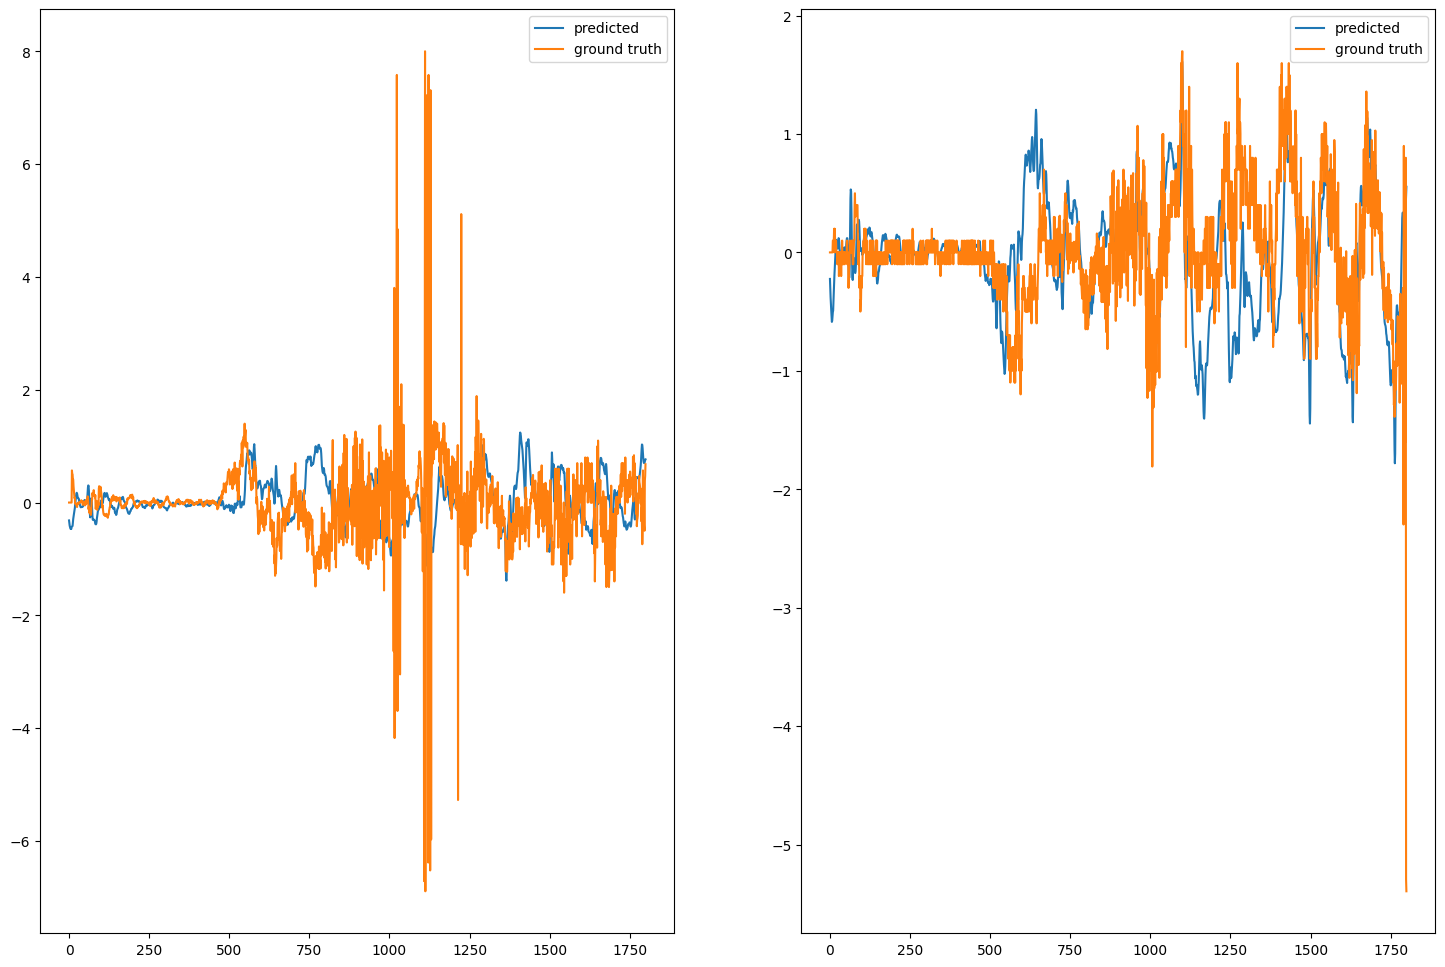

In [321]:
window_size = 10

smooth_acceleration_x = np.convolve(acceleration[:,0], np.ones(window_size)/window_size, mode='valid')
smooth_acceleration_x = np.pad(smooth_acceleration_x,(window_size-1, 0))
smooth_acceleration_y = np.convolve(acceleration[:,1], np.ones(window_size)/window_size, mode='valid')
smooth_acceleration_y = np.pad(smooth_acceleration_y,(window_size-1, 0))

fig, ax = plt.subplots(1,2, figsize = (18,12))
            
ax[0].plot(glob_pred_acceleration[:,0])
ax[0].plot(smooth_acceleration_x)


ax[1].plot(glob_pred_acceleration[:,1])
ax[1].plot(smooth_acceleration_y)

ax[0].legend(['predicted', 'ground truth'])
ax[1].legend(['predicted', 'ground truth'])


In [313]:
acc_diff_x = glob_pred_acceleration[:,0] - np.pad(smooth_acceleration_x,(window_size-1, 0))
acc_diff_y = glob_pred_acceleration[:,1] - np.pad(smooth_acceleration_y,(window_size-1, 0))

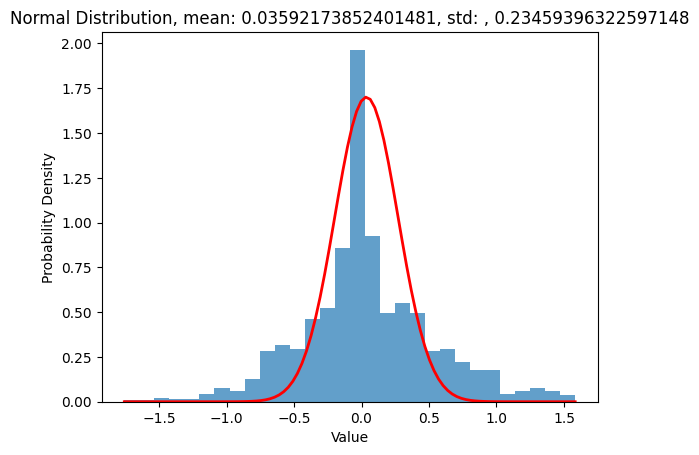

In [314]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random values following a normal distribution
mean = np.mean(acc_diff_x)
std_dev = np.var(acc_diff_x)
num_samples = len(acc_diff_x)  # Number of samples

# Plot the histogram of the samples
plt.hist(acc_diff_x, bins=30, density=True, alpha=0.7)

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(min(acc_diff_x), max(acc_diff_x), 100)
pdf = 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
plt.plot(x, pdf, color='red', linewidth=2)

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title(f'Normal Distribution, mean: {mean}, std: , {std_dev}')
# Show the plot
plt.show()


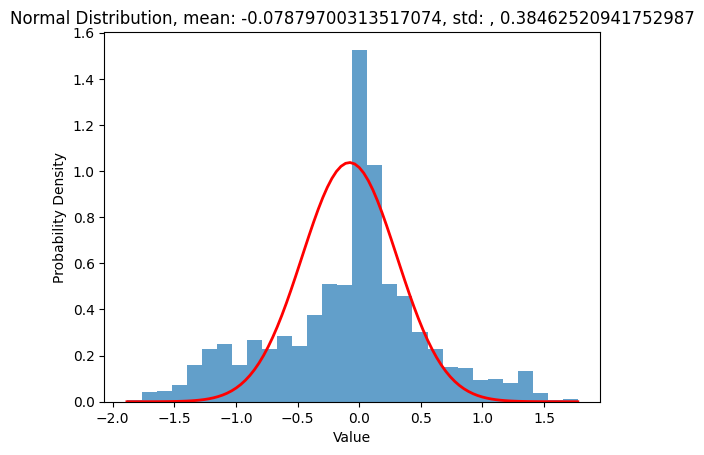

In [315]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random values following a normal distribution
mean = np.mean(acc_diff_y)
std_dev = np.var(acc_diff_y)
num_samples = len(acc_diff_y)  # Number of samples

# Plot the histogram of the samples
plt.hist(acc_diff_y, bins=30, density=True, alpha=0.7)

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(min(acc_diff_y), max(acc_diff_y), 100)
pdf = 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
plt.plot(x, pdf, color='red', linewidth=2)

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title(f'Normal Distribution, mean: {mean}, std: , {std_dev}')

# Show the plot
plt.show()


## This is to convert all the imu and ground truth data into combined files (Not in use now)

In [15]:
# Read the CSV file
def concatData(imu_file_path, gt_file_path, combined_file_path):
    gt_column_names = ['Time', 'Header', 'translation.x', 'translation.y', 'translation.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']

    imu_column_names = ['Time', 'attitude_roll(radians)', 'attitude_pitch(radians)', 'attitude_yaw(radians)',
                'rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)',
                'gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)', 'user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)',
                'magnetic_field_x(microteslas)', 'magnetic_field_y(microteslas)', 'magnetic_field_z(microteslas)']
    imu_data_syn = pd.read_csv(imu_file_path)
    gt_data_syn = pd.read_csv(gt_file_path)
    imu_data_syn.columns = imu_column_names
    gt_data_syn.columns = gt_column_names
    df1 = imu_data_syn[['rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)',
                        'user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)', 'gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)']]
    df2 = gt_data_syn[['translation.x', 'translation.y', 'translation.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']]

    sequence_data = pd.concat([df1,df2], axis = 1)
    sequence_data.to_csv(combined_file_path, index = False)
    print("SUCCESSFULLY COMBINED DATA")
    print("IMU FILE PATH: ", imu_file_path)
    print("GROUNDTRUTH FILE PATH: ", gt_file_path)
    print("COMBINED GROUND TRUTH", combined_file_path)
    print("=================================================================")
    print()
    

In [20]:
folder_path = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset'  # Specify the folder path

# Iterate through all file paths in the folder
for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        for root1, dirs1, files1 in os.walk(dir_path):
            for dir_name1 in dirs1:
                dir_path1 = os.path.join(root1, dir_name1)
                for root2, dirs2, files2 in os.walk(dir_path1 + '/syn'):
                    # files2.sort()
                    # print(dir_path1)
                    # print(files2)
                    # print()
                    length = len(files2)
                    for i in range(int(length/2)):
                        print("i: ", i)
                        print("Length: ", length)
                        imu_file_path = os.path.join(root2, f'imu{i+1}.csv')
                        if os.path.exists(os.path.join(root2, f'vi{i+1}.csv')):
                            gt_file_path = os.path.join(root2, f'vi{i+1}.csv')
                        elif os.path.exists(os.path.join(root2, f'tango{i+1}.csv')):
                            gt_file_path = os.path.join(root2, f'tango{i+1}.csv')
                        output_file_path = os.path.join(dir_path1, f"combined{i+1}.csv")
                        concatData(imu_file_path, gt_file_path, output_file_path)

i:  0
Length:  12
SUCCESSFULLY COMBINED DATA
IMU FILE PATH:  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/syn/imu1.csv
GROUNDTRUTH FILE PATH:  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/syn/vi1.csv
COMBINED GROUND TRUTH /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/combined1.csv

i:  1
Length:  12
SUCCESSFULLY COMBINED DATA
IMU FILE PATH:  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/syn/imu2.csv
GROUNDTRUTH FILE PATH:  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/syn/vi2.csv
COMBINED GROUND TRUTH /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/combined2.csv

i:  2
Length:  12
SUCCESSFULLY COMBINED DATA
IMU FILE PATH:  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/data2/syn/imu3.csv
GROUNDTRUTH FILE PATH:  /home/jovyan/localisation_datasets/Oxford